In [1]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import tensorflow as tf

# convert data to categorial vector representation
from keras.utils import to_categorical

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

2023-06-11 17:26:30.439433: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-11 17:26:30.500455: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-11 17:26:30.502416: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 17:26:32.261831: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Helper function for pre-processing

In [2]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

# Load trained model

In [3]:
model = tf.keras.models.load_model("trained_gesture_model")

In [4]:
annotations = dict()

with open('annot-wagner.json') as f:
    annotations = json.load(f)

In [5]:
# stores actual image data
images = []
# stores labels (as integer - because this is what our network needs)
labels = []
# maps label ints to their actual categories so we can understand predictions later
label_names = []

# loop over all files in the data directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for filename in os.listdir('data'):
    # extract unique ID from file name
    UID = filename.split('.')[0]
    img = cv2.imread(f'data/{filename}')

    # get annotation from the dict we loaded earlier
    try:
        annotation = annotations[UID]
    except Exception as e:
        print(e)
        continue

    # iterate over all hands annotated in the image
    for i, bbox in enumerate(annotation['bboxes']):
        # annotated bounding boxes are in the range from 0 to 1
        # therefore we have to scale them to the image size
        x1 = int(bbox[0] * img.shape[1])
        y1 = int(bbox[1] * img.shape[0])
        w = int(bbox[2] * img.shape[1])
        h = int(bbox[3] * img.shape[0])
        x2 = x1 + w
        y2 = y1 + h

        # crop image to the bounding box and apply pre-processing
        crop = img[y1:y2, x1:x2]
        preprocessed = preprocess_image(crop)

        # get the annotated hand's label
        # if we have not seen this label yet, add it to the list of labels
        label = annotation['labels'][i]
        if label not in label_names:
            label_names.append(label)

        label_index = label_names.index(label)

        images.append(preprocessed)
        labels.append(label_index)

# Create test dataset

In [6]:
X_test = np.array(images).astype('float32')
X_test = X_test / 255.

y_test = labels
y_test_one_hot = to_categorical(y_test)

test_label = y_test_one_hot

X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

# Create confusion matix

1/1 [==============================] - 0s 273ms/step


2023-06-11 17:26:37.257743: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20971520 exceeds 10% of free system memory.


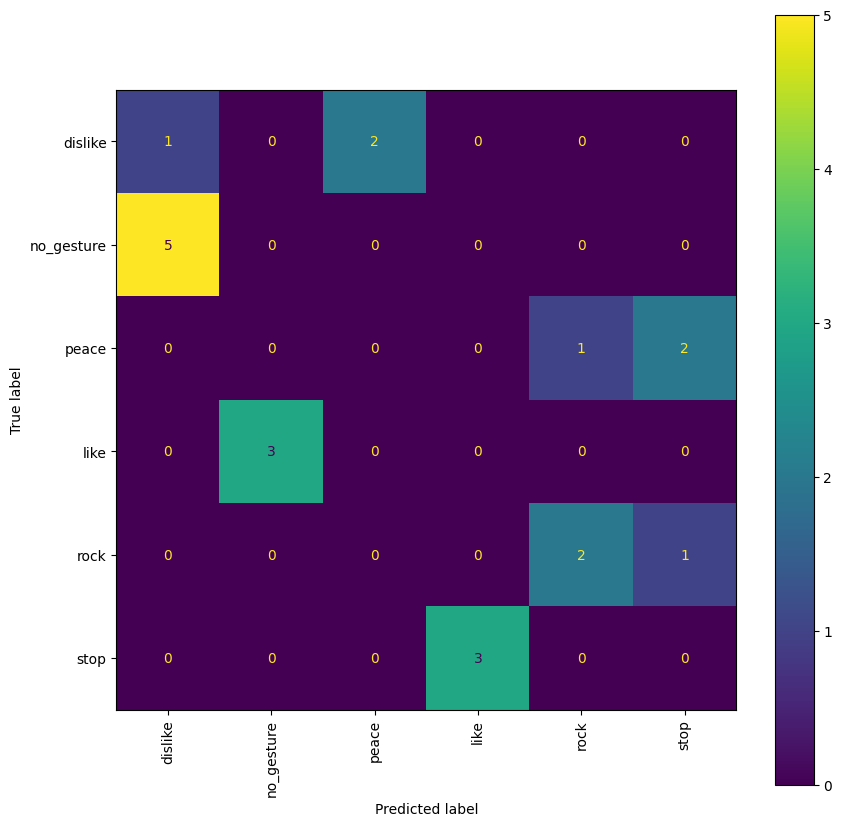

In [7]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# for prediction in y_predictions:
#     print(label_names[np.argmax(prediction)], np.max(prediction))

# we get a 2D numpy array with probabilities for each category
# print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

# print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(
    conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass